#### From: 2020.06.17
#### To: 2020.07.01

## Image segmentation with IXI - all slices in the firts dimension (out of plane resolution)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = Path('/data-10tb/marek/IXI/fastai/data2d')
path.ls()

FileNotFoundError: [Errno 2] No such file or directory: '/data-10tb/marek/IXI/fastai/data2d'

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:2]

[PosixPath('/data-10tb/marek/IXI/fastai/data2d/images/IXI476-IOP-1140-T1.anat_T1_biascorr_036.png'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d/images/IXI166-Guys-0846-T1.anat_T1_biascorr_048.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:2]

[PosixPath('/data-10tb/marek/IXI/fastai/data2d/labels/IXI481-HH-2175-T1.anat_T1_biascorr_041_M.png'),
 PosixPath('/data-10tb/marek/IXI/fastai/data2d/labels/IXI356-HH-2049-T1.anat_T1_biascorr_071_M.png')]

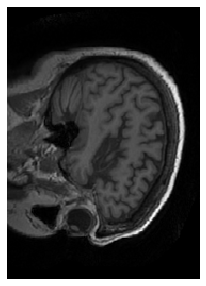

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_M{x.suffix}'

In [9]:
print(img_f)
print(get_y_fn(img_f))

/data-10tb/marek/IXI/fastai/data2d/images/IXI476-IOP-1140-T1.anat_T1_biascorr_036.png
/data-10tb/marek/IXI/fastai/data2d/labels/IXI476-IOP-1140-T1.anat_T1_biascorr_036_M.png


In [10]:
# print(img_f)
# print()
# print(img_f.stem)
# print()
# print(img_f.suffix)
# print()
# get_y_fn(img_f)

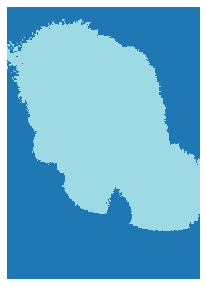

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
# mask.shape, src_size, mask.data

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['background', 'brain'], dtype='<U10')

In [14]:
len(codes)

2

**WAZNA KOMORKA!!!!!! - ZARZADZANIE PAMIECIA!!!**

In [15]:
#size = src_size//2 # oryg
size = src_size // 2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=16
else:           bs=8
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=16, have 23328MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img) # we jave a list of image files that are in a folder
       .split_by_rand_pct(valid_pct=0.2, seed=42)
       .label_from_func(get_y_fn, classes=codes))  # we need a labels form function we have just 
                                                   # created and a txt file

In [17]:
# we create a data sets

# tfm_y we want to transform mask as well, image oryg (x) and mask (y)
data = (src.transform(get_transforms(), size=size, tfm_y=True) 
        .databunch(bs=bs)
        .normalize(imagenet_stats))

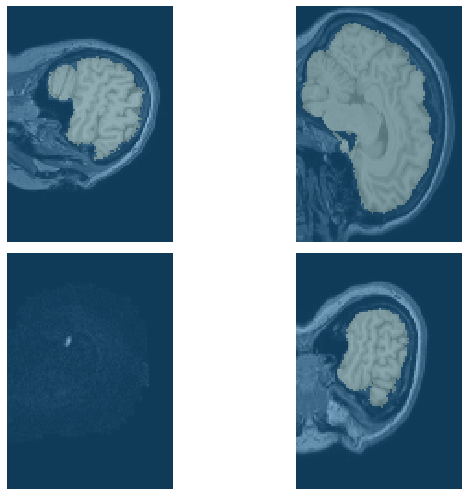

In [18]:
# show_batch combines both images for us, oryginal (x) and mask (y)
data.show_batch(2, figsize=(10,7))

In [19]:
#data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
wd=1e-2

In [21]:
#torch.cuda.empty_cache()

In [22]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd)

In [23]:
lr_find(learn)

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.37E-04


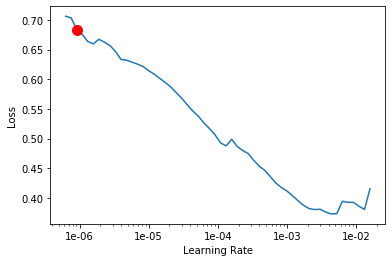

In [24]:
learn.recorder.plot(suggestion=True)

In [25]:
lr=1e-6 # oryginal

In [26]:
#learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.068803,0.055835,0.915851,06:00
1,0.071096,0.054225,0.902082,04:52
2,0.057881,0.051902,0.908716,04:54


In [38]:
learn.save('stage-1')

In [41]:
learn.load('stage-1');

In [42]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,dice,time
0,0.057306,0.047038,0.920185,07:16


In [44]:
#learn.load('stage-1')

In [44]:
#learn.save('stage-2')

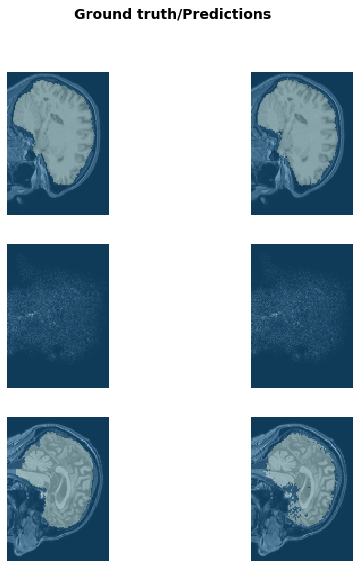

In [45]:
learn.show_results(rows=3, figsize=(8,9))

In [46]:
learn.unfreeze()

epoch,train_loss,valid_loss,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-06


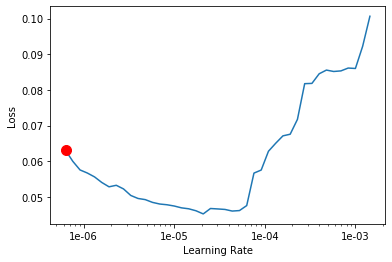

In [47]:
lr_find(learn)
learn.recorder.plot(suggestion=True)

In [48]:
lrs = slice(1e-7,lr/5)

In [49]:
# learn.fit_one_cycle(10, lrs, pct_start=0.8)
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,dice,time
0,0.043746,0.046000,0.929441,08:01
1,0.045651,0.045643,0.927885,07:59
2,0.053340,0.045970,0.923198,07:57


In [50]:
learn.save('stage-2');

In [51]:
learn.load('stage-2');

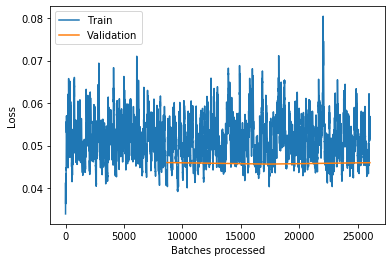

In [52]:
learn.recorder.plot_losses()

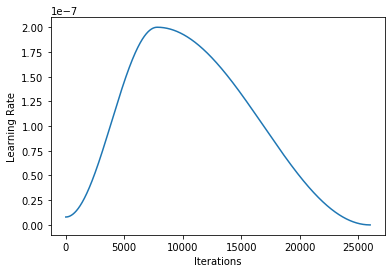

In [53]:
learn.recorder.plot_lr()

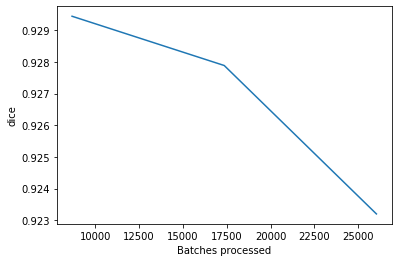

In [54]:
learn.recorder.plot_metrics()